# Approches hybrides : réseaux de neurones

Pierrick DOSSIN  
Guillaume RIU 

In [73]:
!pip install tfds-nightly
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets==4.3
!pip install -q scann

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached protobuf-4.22.3-cp37-abi3-manylinux2014_x86_64.whl (302 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.22.3 which is incompatible.
tensorboard 2.11.2 requires protobuf<4,>=3.9.2, but you have protobuf 4.22.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfds-nightly 4.9.2.dev202304300044 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.

In [74]:
import os
import pprint
import tempfile

from tqdm import tqdm
from typing import Dict, Text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_recommenders as tfrs
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Sequential
from keras.backend import dropout

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine


#### Charger les données

In [114]:
# Chargement des données
movie_features = pd.read_csv('Data/items.csv')
user_features  = pd.read_csv('Data/u.csv')
votes_df   = pd.read_csv('Data/votes.csv')

## Matrice Utilisateur Item
MUI = votes_df.pivot(index="user.id", columns="item.id", values="rating").astype('float32')

votes_df   = votes_df.rename(columns={'user.id': 'user_id', 'item.id': 'movie_id', 'rating': 'user_rating', 'timestamp': 'timestamp'})
votes_tf  = tf.data.Dataset.from_tensor_slices(tf.cast(votes_df.values, tf.float32))

# Extraction des attributs
votes = votes_tf.map(lambda x: {"user_id": tf.strings.as_string(x[0]), "movie_id": tf.strings.as_string(x[1]), "user_rating": x[2]})

In [115]:
id_films = votes.map(lambda x: x["movie_id"]).batch(1000000)
films_unique = np.unique(np.concatenate(list(id_films)))
nb_films_unique = films_unique.shape[0]
print(f"Nombre de films : {nb_films_unique}")

id_utilisateurs = votes.map(lambda x: x["user_id"]).batch(1000000)
utilisateurs_unique = np.unique(np.concatenate(list(id_utilisateurs)))
nb_utilisateurs_unique = utilisateurs_unique.shape[0]
print(f"Nombre d'utilisateurs : {nb_utilisateurs_unique}")

Nombre de films : 1682
Nombre d'utilisateurs : 943


### Métriques MSE et MAE

In [116]:
task = tfrs.tasks.Ranking(loss = tf.keras.losses.MeanSquaredError(), metrics = [tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

### Facteurs de succès

In [117]:
def recommandations_list(votes_predits, nmb_reco):
    # liste des meilleurs recommandations n'ayant pas déjà été vues
    return np.argsort(np.array(-votes_predits * np.isnan(MUI)))[:,:nmb_reco]

In [118]:
def diversite(votes_observes, votes_predits, nmb_reco):
    diversite = 0
    reco = recommandations_list(votes_predits, nmb_reco)
    votes_observes = votes_observes.replace(np.nan, 0)
    # Matrice des similarités item selon les votes observés
    cosine_similarity = 1 - pairwise_distances(votes_observes.T, metric="cosine")
    for u in range(votes_observes.shape[0]):
        for i in range(nmb_reco):
            for j in range(nmb_reco):
                if i!= j:
                    diversite += cosine_similarity[reco[u][i], reco[u][j]]
    diversite /= nmb_reco * (nmb_reco - 1) * votes_observes.shape[0]
    return diversite

In [119]:
def nouveaute(votes_observes, votes_predits, nmb_reco):
    nouveaute = 0
    reco = recommandations_list(votes_predits, nmb_reco)
    MUI_zero_one = votes_observes.replace(np.nan, 0)
    MUI_zero_one[MUI_zero_one > 0] = 1
    proportion_visionnage_item = np.nanmean(MUI_zero_one, axis=0)
    for u in range(votes_observes.shape[0]):
        for i in range(nmb_reco):
            nouveaute += -np.log2(proportion_visionnage_item[reco[u][i]])
    nouveaute /= nmb_reco * len(votes_observes)
    return nouveaute

In [120]:
def couverture(votes_observes, votes_predits, nmb_reco):
    reco = recommandations_list(votes_predits, nmb_reco)
    nb_item_reco = len(np.unique(reco))
    nb_item = votes_observes.shape[1]
    couverture = nb_item_reco / nb_item
    return couverture

In [121]:
def utilite(votes_observes, votes_predits, nmb_reco):
    # Moyenne des meilleurs recommandations
    reco = np.sort(np.array(-votes_predits))[:,:nmb_reco]
    return -np.mean(reco)

In [122]:
def p(MUI_nan, i, j = None):
    if (j==None):
        nan = sum(MUI_nan[:,i]) 
        return (MUI.shape[0] - nan) / MUI.shape[0]
    else:
        nan = sum(MUI_nan[:,i] * MUI_nan[:,j])
        return (MUI.shape[0] - nan) / MUI.shape[0]

In [123]:
def aime_list(votes_observes, nmb_reco):
    MUI_zero_one = votes_observes.replace(np.nan, 0)
    return np.argsort(np.array(-MUI_zero_one))[:,:nmb_reco]

In [124]:
def serendipite(votes_observes, votes_predits, nmb_reco):
    MUI_nan = np.array(np.isnan(votes_observes))
    reco = recommandations_list(votes_predits, nmb_reco)
    aime = aime_list(votes_observes, nmb_reco)
    pmi = 0
    for u in range(votes_observes.shape[0]):
        for i in reco[u]:
            for j in aime[u]:
                pmi += np.log2(p(MUI_nan, i,j)/(p(MUI_nan, i)*p(MUI_nan, j)))
    pmi /= nmb_reco * nmb_reco * votes_observes.shape[0]
    return pmi

In [125]:
def calcul_facteur(votes_observes, votes_predits, facteur, nmb_reco):
    if facteur == "serendipite":
        return serendipite(votes_observes, votes_predits, nmb_reco)
    elif facteur == "utilite":
        return utilite(votes_observes, votes_predits, nmb_reco)
    elif facteur == "couverture":
        return couverture(votes_observes, votes_predits, nmb_reco)
    elif facteur == "nouveaute":
        return nouveaute(votes_observes, votes_predits, nmb_reco)
    elif facteur == "diversite":
        return diversite(votes_observes, votes_predits, nmb_reco)


In [126]:
# Définition des couches de plongement pour les utilisateurs et les films
def initialisation_embeddings(embedding_dimension, id_uniques, films_unique):
    user_model = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=id_uniques, mask_token=None),
                                    tf.keras.layers.Embedding(len(id_uniques) + 1,# Le +1 représente la constante $c$
                                                                embedding_dimension)], name="User_Embedding")

    movie_model = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=films_unique,mask_token=None),
                                    tf.keras.layers.Embedding(len(films_unique) + 1, 
                                                                embedding_dimension)], name="Movie_Embedding")  
    return user_model, movie_model

#### Définir les bases de données d'entrainement et de validation (proportion $80\%-20\%$).

In [127]:
N = len(votes)
batch_size = 8192
prop = 0.8
embedding_dimension = 64
train_len  = tf.cast(N * prop, dtype=tf.int64)
valid_len   = tf.cast(N - train_len, dtype=tf.int64)

tf.random.set_seed(73)
train = votes.take(train_len).shuffle(train_len, seed=73, reshuffle_each_iteration=False).batch(batch_size)
valid = votes.skip(train_len).take(valid_len).shuffle(valid_len, seed=73, reshuffle_each_iteration=False).batch(batch_size)

In [128]:
# On tire un exemple pour construire le graphe du modèle
feature = next(iter(train))

# Modèle Two Tower
Nous allons implanter le modèle *Two Tower* afin de prédire les votes de la manière suivante :

$$pred_{i,j}= \sigma(b + biais_{u_i} + biais_{f_j} +E_{u_i}^TE_{f_j}) \times (M_{vote} - m_{vote}) + m_{vote} $$
<br>

Où $(E_{u_i}, E_{f_j}) \in \mathbb{R}^n \times \mathbb{R}^n$ sont respectivement les embeddings de l'utilisateur $i$, $u_i$, et du film $j$, $f_j$.

$b \in \mathbb{R}$ est la constante qui représente la moyenne. 

$n \in \mathbb{N}$ est la dimension de l'espace latent des utilisateurs et des films.

$biais_{u_i} \in \mathbb{R}$ est le biais associé à l'utilisateur $u_i$

$biais_{f_j} \in \mathbb{R}$ le biais associé au film $f_j$. 

$\sigma$ est la fonction sigmoïde.

$M_{vote}$ et $m_{vote}$ sont respectivement les valeurs maximale et minimale possibles pour les votes.

In [129]:
#MovieLensModelWithBias Herite des attributs et des méthodes de MovieLensModel
class MovieLensModelWithBias(tfrs.models.Model):

  def __init__(self, embedding_dimension, id_uniques, films_unique, task, min_vote=1, max_vote=5):
    super().__init__()

    self.user_model, self.movie_model = initialisation_embeddings(embedding_dimension, id_uniques, films_unique)
    
    self.pred = tf.keras.layers.Dot(axes=1)
    
    self.task: tf.keras.layers.Layer = task

    self.min_vote, self.max_vote = min_vote, max_vote

    self.user_bias = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=id_uniques, mask_token=None),
                                    tf.keras.layers.Embedding(len(id_uniques) + 1, 1)], name="User_Bias")

    self.movie_bias = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=films_unique, mask_token=None),
                                    tf.keras.layers.Embedding(len(films_unique) + 1, 1)], name="Movie_Bias")

    self.user_dropout  = tf.keras.layers.Dropout(rate = 0.3, name="User_Dropout")
    self.movie_dropout = tf.keras.layers.Dropout(rate = 0.6, name="Movie_Dropout")

  def call(self, features):
    bias_u = self.user_dropout(self.user_bias(features['user_id']))
    bias_i = self.movie_dropout(self.movie_bias(features['movie_id']))
    two_tower = self.pred([self.user_model(features['user_id']), self.movie_model(features['movie_id'])])
    return tf.math.sigmoid(two_tower + bias_u + bias_i) * (self.max_vote - self.min_vote) + self.min_vote
  
  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    return self.task(labels=features["user_rating"], predictions=self.call(features))

In [130]:
#Initialisez le modèle et afficher ses couches (summary)
Model_TwoTowers = MovieLensModelWithBias(embedding_dimension, utilisateurs_unique, films_unique, task)
Model_TwoTowers(feature)
Model_TwoTowers.summary()


Model_TwoTowers.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]
history_TwoTowers = Model_TwoTowers.fit(train, epochs=30, validation_data=valid, callbacks=my_callbacks)


Model: "movie_lens_model_with_bias_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 User_Embedding (Sequential)  (8192, 64)               60416     
                                                                 
 Movie_Embedding (Sequential  (8192, 64)               107712    
 )                                                               
                                                                 
 dot_2 (Dot)                 multiple                  0         
                                                                 
 ranking_2 (Ranking)         multiple                  0 (unused)
                                                                 
 User_Bias (Sequential)      (8192, 1)                 944       
                                                                 
 Movie_Bias (Sequential)     (8192, 1)                 1683      
                                      

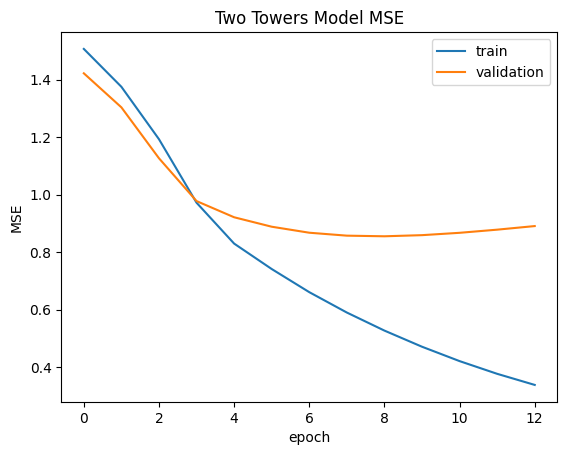

Erreur MSE modèle Two Tower : 0.8553
Erreur MAE modèle Two Tower : 0.7373


In [131]:
# Affichage des résultats
plt.plot(history_TwoTowers.history['mean_squared_error'])
plt.plot(history_TwoTowers.history['val_mean_squared_error'])
plt.title("Two Towers Model MSE")
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()
print("Erreur MSE modèle Two Tower : {0:.4f}".format(min(history_TwoTowers.history['val_mean_squared_error'])))
print("Erreur MAE modèle Two Tower : {0:.4f}".format(history_TwoTowers.history['val_mean_absolute_error'][np.argmin(history_TwoTowers.history['val_mean_squared_error'])]))


In [132]:
pred_valid_TwoTowers = Model_TwoTowers.predict(valid)

# Transformer l'ensemble de validation en itérateur numpy
valid_iter = valid.as_numpy_iterator()

# Récupérer les ID d'utilisateur et d'élément correspondants
user_ids = []
item_ids = []
for batch in valid_iter:
  user_ids.extend(batch['user_id'].tolist())
  item_ids.extend(batch['movie_id'].tolist())

# Transformer les ID d'utilisateur et d'élément en tableaux numpy
user_ids = np.array(user_ids).astype(float)
item_ids = np.array(item_ids).astype(float)

MUI_pred = pd.DataFrame(np.zeros_like(MUI))
MUI_pred.columns = MUI.columns
MUI_pred.index = MUI.index

for i in range(len(user_ids)):
  MUI_pred.loc[user_ids[i], item_ids[i]] = pred_valid_TwoTowers[i][0]

MUI_pred = MUI_pred.to_numpy().astype(np.float32)

3/3 [==============================] - 4s 13ms/step


In [133]:
print("Facteur de succès de l'approche TwoTowers :")
print("utilite = ", calcul_facteur(MUI, MUI_pred, "utilite", 10))
print("diversite = ", calcul_facteur(MUI, MUI_pred, "diversite", 10))
print("nouveaute = ", calcul_facteur(MUI, MUI_pred, "nouveaute", 10))
print("serendipite = ", calcul_facteur(MUI, MUI_pred, "serendipite", 10))
print("couverture = ", calcul_facteur(MUI, MUI_pred, "couverture", 10))

Facteur de succès de l'approche TwoTowers :
utilite =  2.9377518
diversite =  0.10707916948530409
nouveaute =  6.218138408660889
serendipite =  6.484041722788741
couverture =  0.005945303210463734


# Modèle AutoREC

In [105]:
valid_split = 0.2
votes_train_df, votes_valid_df  = train_test_split(votes_df, test_size=valid_split)

train_mat = votes_train_df.pivot(votes_train_df.columns[0], votes_train_df.columns[1], votes_train_df.columns[2])
valid_mat = votes_valid_df.pivot(votes_train_df.columns[0], votes_train_df.columns[1], votes_train_df.columns[2])

col_list = list(set().union(train_mat.columns, valid_mat.columns))
col_list.sort()

train_mat = train_mat.reindex(columns=col_list, fill_value=np.nan)
valid_mat = valid_mat.reindex(columns=col_list, fill_value=np.nan)

train_mat.fillna(0, inplace=True)
valid_mat.fillna(0, inplace=True)


<ipython-input-105-5611c5beaaf9>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  train_mat = votes_train_df.pivot(votes_train_df.columns[0], votes_train_df.columns[1], votes_train_df.columns[2])
<ipython-input-105-5611c5beaaf9>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  valid_mat = votes_valid_df.pivot(votes_train_df.columns[0], votes_train_df.columns[1], votes_train_df.columns[2])


In [107]:
class AutoREC(tf.keras.Model):
    def __init__(self, input_len, output_len=None, min_vote=1, max_vote=5, dropout=0.5, name="MovieLensAutoEncoder"):
        super(AutoREC, self).__init__()
        
        model = Sequential(name=name)
        model.add(tf.keras.Input(shape=(input_len,)))
        model.add(layers.Dropout(rate = dropout))
        model.add(layers.Dense(500, activation="sigmoid", name="DenseLayer1"))
        model.add(layers.Dropout(rate = dropout))
        model.add(layers.Dense(250, activation="sigmoid", name="DenseLayer2"))
        model.add(layers.Dropout(rate = dropout))
        model.add(layers.Dense(500, activation="sigmoid", name="DenseLayer3"))
        model.add(layers.Dense(output_len, activation="sigmoid", name="DenseLayer4")) 

        self.model = model
        self.min_vote = min_vote
        self.max_vote = max_vote



    def summary(self):
        self.model.summary()

    def call(self, x, training=None):
        return self.model(x, training) * (self.max_vote-self.min_vote) + self.min_vote

In [108]:
# Pour le modèle AutoREC nous devons utiliser une version de modifiée de la RMSE qui ne prend pas en compte les valeurs de votes manquantes
class ModifiedRootMeanSquarredError(tf.keras.losses.MeanSquaredError):
    def __init__(self, nb_items):
        super(ModifiedRootMeanSquarredError, self).__init__()
        self.nb_items = nb_items

    def __call__(self, y_true, y_pred, sample_weight=None):
        y_true = y_true[:, :self.nb_items]
        y_pred = y_pred[:, :self.nb_items]
        return tf.math.sqrt(super(ModifiedRootMeanSquarredError, self).__call__(y_true[y_true > 0], y_pred[y_true > 0], sample_weight))

class ModifiedMeanSquarredError(tf.keras.losses.MeanSquaredError):
    def __init__(self, nb_items):
        super(ModifiedMeanSquarredError, self).__init__()
        self.nb_items = nb_items

    def __call__(self, y_true, y_pred, sample_weight=None):
        y_true = y_true[:, :self.nb_items]
        y_pred = y_pred[:, :self.nb_items]
        return super(ModifiedMeanSquarredError, self).__call__(y_true[y_true > 0], y_pred[y_true > 0], sample_weight)

class ModifiedMeanAbsoluteError(tf.keras.losses.MeanAbsoluteError):
    def __init__(self, nb_items):
        super(ModifiedMeanAbsoluteError, self).__init__()
        self.nb_items = nb_items

    def __call__(self, y_true, y_pred, sample_weight=None):
        y_true = y_true[:, :self.nb_items]
        y_pred = y_pred[:, :self.nb_items]
        return super(ModifiedMeanAbsoluteError, self).__call__(y_true[y_true > 0], y_pred[y_true > 0], sample_weight)

In [109]:
batch_size = 64
buffer_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((train_mat.to_numpy(), train_mat.to_numpy()))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_mat.to_numpy(), valid_mat.to_numpy()))

train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size) 

In [110]:
lr = 1e-3
epochs = 100
dropout = 0.5
input_len  = train_mat.shape[1]
output_len = train_mat.shape[1]

my_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/checkpoint',
                  save_weights_only=True,
                  monitor='val_loss',
                  mode='max',
                  save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=5)]

autorec = AutoREC(input_len, output_len, dropout=dropout)

autorec.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=ModifiedRootMeanSquarredError(output_len), metrics=[ModifiedMeanSquarredError(output_len), ModifiedMeanAbsoluteError(output_len)])

history_autorec = autorec.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, callbacks=my_callbacks)

Epoch 1/100
15/15 [==============================] - 2s 35ms/step - loss: 1.0887 - mean_squared_error: 1.1914 - mean_absolute_error: 0.8753 - val_loss: 1.0440 - val_mean_squared_error: 1.0915 - val_mean_absolute_error: 0.8350
Epoch 2/100
15/15 [==============================] - 0s 9ms/step - loss: 1.0145 - mean_squared_error: 1.0308 - mean_absolute_error: 0.8163 - val_loss: 1.0275 - val_mean_squared_error: 1.0571 - val_mean_absolute_error: 0.8255
Epoch 3/100
15/15 [==============================] - 0s 9ms/step - loss: 1.0067 - mean_squared_error: 1.0134 - mean_absolute_error: 0.8032 - val_loss: 1.0282 - val_mean_squared_error: 1.0586 - val_mean_absolute_error: 0.8274
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: 1.0054 - mean_squared_error: 1.0112 - mean_absolute_error: 0.8043 - val_loss: 1.0265 - val_mean_squared_error: 1.0552 - val_mean_absolute_error: 0.8247
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 1.0015 - mean_squared_err

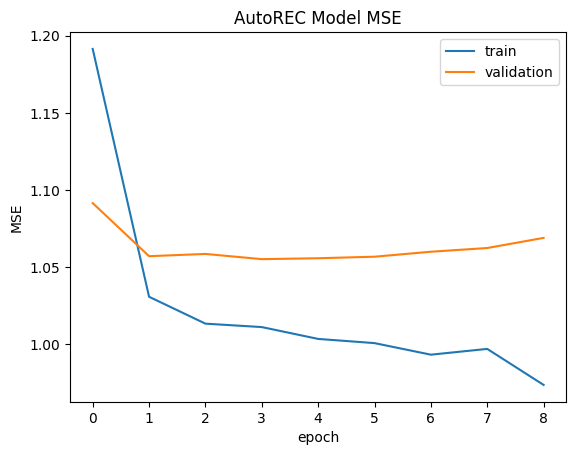

Erreur MSE modèle AutoREC : 1.0552
Erreur MAE modèle AutoREC : 0.7338


In [111]:
# Affichage des résultats
plt.plot(history_autorec.history['mean_squared_error'])
plt.plot(history_autorec.history['val_mean_squared_error'])
plt.title('AutoREC Model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()
print("Erreur MSE modèle AutoREC : {0:.4f}".format(min(history_autorec.history['val_mean_squared_error'])))
print("Erreur MAE modèle AutoREC : {0:.4f}".format(history_TwoTowers.history['val_mean_absolute_error'][np.argmin(history_TwoTowers.history['val_mean_squared_error'])]))

In [113]:
valid_tensor = tf.convert_to_tensor(valid_mat.to_numpy(), dtype=tf.float32)
MUI_pred = AutoREC(input_len=valid_tensor.shape[1], output_len=valid_tensor.shape[1])(valid_tensor).numpy()

print("Facteur de succès de l'approche AutoRec :")
print("utilite = ", calcul_facteur(MUI, MUI_pred, "utilite", 10))
print("diversite = ", calcul_facteur(MUI, MUI_pred, "diversite", 10))
print("nouveaute = ", calcul_facteur(MUI, MUI_pred, "nouveaute", 10))
print("serendipite = ", calcul_facteur(MUI, MUI_pred, "serendipite", 10))
print("couverture = ", calcul_facteur(MUI, MUI_pred, "couverture", 10))

Facteur de succès de l'approche AutoRec :
utilite =  3.8915844
diversite =  0.060184867464640655
nouveaute =  6.314993386051182
serendipite =  6.599607281289177
couverture =  0.011296076099881093
